In [1]:
import numpy as np
import pandas as pd
import random
import json
path = "../data/mark.json"
with open(path) as f:
    data = json.load(f)

#提取数据
num = 480
other_n = 1.5
a0 = np.array(random.sample(data['0'], num))
l0 = np.ones((num))*0
a1 = np.array(random.sample(data['1'], num))
l1 = np.ones((num))*1
a2 = np.array(random.sample(data['2'], num))
l2 = np.ones((num))*2
a5 = np.array(random.sample(data['5'], num))
l5 = np.ones((num))*3

other = np.array(random.sample(data['other'], int(num*other_n)))
l_other = np.ones(int(num*other_n))*4

all_label = np.hstack((l0,l1,l2,l5,))
all_data = np.vstack((a0,a1,a2,a5,))

'''
手势识别模块
只传入20个节点

'''
# 
def cal_l(list):
    l = []

    for x in list:
        juli = (x[0]**2+x[1]**2) 
        l.append(juli)

    new_list = [
                l[2],l[3],l[4],
                l[6],l[7],l[8],
                l[10],l[11],l[12],
                l[14],l[15],l[16],
                l[18],l[19],l[20]
                ]
    return (new_list)

all_data_ = []
for i in all_data:
    all_data_.append(cal_l(i))

all_data = np.array(all_data_)


'''
打乱
'''
state = np.random.get_state()
np.random.shuffle(all_data)
np.random.set_state(state)
np.random.shuffle(all_label)
'''
data:  ndarray --> tensor
torch.Size([bs, 20])
label: list --> tensor
torch.Size([bs])

'''

/Users/mac/opt/anaconda3/envs/z-cv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


'\ndata:  ndarray --> tensor\ntorch.Size([bs, 20])\nlabel: list --> tensor\ntorch.Size([bs])\n\n'

In [2]:
(all_data[1]).reshape(-1,).shape

(15,)

In [3]:
'''
训练数据 生成器 (generate)

有时间改一改
'''

r = int(len(all_data)*0.75)
v_r = int(len(all_data)*0.05)
def bz_generate(bz, type:str = "train"):
    inputs = []
    targets = []
    if type == "train":
        datas = all_data[:r]
        labels = all_label[:r]
    elif type == "test":
        datas = all_data[r:]
        labels = all_label[r:]
    elif type == 'verify' :
        datas = all_data[r-v_r:r+v_r]
        labels = all_label[r-v_r:r+v_r]


    '''
        修改data shape
        以batch size 返回
    '''
    for index, d in enumerate(datas):
        inputs.append(d.reshape(-1,))
        targets.append(labels[index])
        if len(inputs) == bz:
            tmp_inp = np.array(inputs)
            tmp_targets = np.array(targets)
            inputs = []
            targets = []
            yield (tmp_inp, tmp_targets)

'''
计算准确率
'''
def cul_acc(type):
    correct = 0
    total = 0
    gen = bz_generate(4, type)
    with torch.no_grad():
        for data in gen:
            inputs, labels = data
            inputs = Variable(torch.from_numpy(inputs).type(torch.FloatTensor))
            labels = Variable(torch.from_numpy(labels).type(torch.FloatTensor))
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
    return (100 * correct / total)

In [4]:
import torch
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Sequential, Linear, ReLU, Dropout, Sigmoid, Tanh, Softmax
import torch.optim as optim
from torch.autograd import Variable

In [5]:
'''

'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = Sequential(
            Linear(15, 10),
            Tanh(),
            Linear(10, 4),
            Softmax()
        )

    def forward(self, x):
        x = self.layers(x)
        return x
net = Net()

loss_list = []
train_acc_list = []

In [8]:

def train_(epo=2, lr=0.001):
    print('start!')
    criterion = nn.MultiMarginLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epo):  # loop over the dataset multiple times
        t1 = time()
        train_acc = 0.0
        running_loss = 0.0
        gen = bz_generate(8)
        for i, item in enumerate(gen): 
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = item
            inputs = Variable(torch.from_numpy(inputs).type(torch.FloatTensor))
            labels = Variable(torch.from_numpy(labels).type(torch.FloatTensor))

            optimizer.zero_grad()
            outputs = net(inputs)
            labels = labels.type(torch.LongTensor)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _acc = cul_acc("train")
            # if _acc>0.7:
            #     break

            running_loss += loss.item()
            train_acc += _acc
            
        loss_list.append(running_loss/i)
        train_acc_list.append(train_acc/i)
        print(f'{epoch}、 time:{str(time()-t1)[:4]}s - loss:{str(loss_list[-1])[:5]} - acc: {str(train_acc_list[-1])[:5]}%')

        '''
         test loss
        '''
        with torch.no_grad():
            gen = bz_generate(8, 'verify')
            test_loss = 0
            for i, item in enumerate(gen): 
                inputs, labels = item
                inputs = Variable(torch.from_numpy(inputs).type(torch.FloatTensor))
                labels = Variable(torch.from_numpy(labels).type(torch.FloatTensor))

                optimizer.zero_grad()
                outputs = net(inputs)
                labels = labels.type(torch.LongTensor)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            print(f't_loss:{str(test_loss/i)[:6]}')

    print('Finished Training')






In [10]:
train_(50)

start!
0、 time:10.4s - loss:0.502 - acc: 50.90%
t_loss:0.5870
1、 time:10.4s - loss:0.502 - acc: 50.92%
t_loss:0.5867
2、 time:9.73s - loss:0.502 - acc: 50.93%
t_loss:0.5865
3、 time:9.47s - loss:0.502 - acc: 50.97%
t_loss:0.5863
4、 time:9.45s - loss:0.502 - acc: 50.99%
t_loss:0.5860
5、 time:10.7s - loss:0.501 - acc: 51.01%
t_loss:0.5858
6、 time:10.1s - loss:0.501 - acc: 51.03%
t_loss:0.5856
7、 time:9.70s - loss:0.501 - acc: 51.05%
t_loss:0.5854
8、 time:10.4s - loss:0.501 - acc: 51.06%
t_loss:0.5851
9、 time:10.2s - loss:0.501 - acc: 51.08%
t_loss:0.5849
10、 time:10.1s - loss:0.501 - acc: 51.10%
t_loss:0.5847
11、 time:9.81s - loss:0.501 - acc: 51.10%
t_loss:0.5845
12、 time:10.3s - loss:0.500 - acc: 51.11%
t_loss:0.5843
13、 time:9.98s - loss:0.500 - acc: 51.10%
t_loss:0.5841
14、 time:9.89s - loss:0.500 - acc: 51.10%
t_loss:0.5839
15、 time:10.3s - loss:0.500 - acc: 51.10%
t_loss:0.5837
16、 time:10.5s - loss:0.500 - acc: 51.10%
t_loss:0.5835
17、 time:13.4s - loss:0.500 - acc: 51.11%
t_loss:0.

KeyboardInterrupt: 

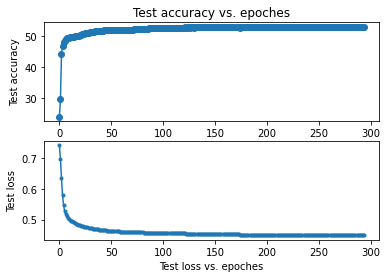

In [86]:
#

import matplotlib.pyplot as plt

def draw_tabel(acc_list, loss_list):
    x1 = range(0, len(acc_list))
    x2 = range(0, len(loss_list))
    y1 = acc_list
    y2 = loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()

draw_tabel(train_acc_list, loss_list)

In [87]:
def class_statistics(num, dataset):
    class_correct = list(0. for i in range(num)) 
    class_total = list(0 for i in range(num)) 
    class_err = list(0 for i in range(num)) 
    with torch.no_grad():
        for data in dataset:
            inputs, labels = data
            inputs = Variable(torch.from_numpy(inputs).type(torch.FloatTensor))
            labels = Variable(torch.from_numpy(labels).type(torch.FloatTensor))
            outputs = net(inputs)
            
            _, predicted = torch.max(outputs, 1)
            
            c = (predicted == labels).squeeze() 

            label = int(labels[0])
            class_total[label] = class_total[label]+1
            if c.item():
                class_correct[label] = class_correct[label]+1
            else:

                class_err[predicted.item()]+=1
                p = outputs[0][predicted.item()]
                if p >0.9:
                    print(label,predicted.item())
        all_acc = 0



        for i in range(num):
        
            print(f'class{i+1} total: {class_total[i]} -- acc: {str(class_correct[i]/class_total[i]*100)[:4]}%')
            all_acc += (class_correct[i]/class_total[i])

        print(class_err)
        print(all_acc/num)

test_data = bz_generate(1, 'test')
class_statistics(4, test_data)

3 1
2 0
3 0
3 0
3 1
0 1
0 1
3 0
3 1
3 1
1 0
2 1
3 1
2 1
2 1
2 0
3 1
1 0
2 1
3 1
3 1
3 1
3 2
2 1
2 1
2 0
2 0
2 0
2 0
3 0
2 1
3 2
2 1
3 2
2 1
2 1
3 1
0 1
3 1
2 0
2 1
3 1
0 1
2 1
1 0
3 1
3 1
3 2
2 1
3 0
3 1
2 1
2 1
2 1
3 0
3 0
0 1
0 1
3 2
3 2
3 2
2 1
0 1
3 0
3 0
3 0
2 1
class1 total: 121 -- acc: 69.4%
class2 total: 99 -- acc: 75.7%
class3 total: 137 -- acc: 37.9%
class4 total: 123 -- acc: 21.9%
[27, 151, 40, 24]
0.5127162181315968


In [1]:
import time
try:
    for i in range(5):
        print(i)
        time.sleep(3)
except:
    print('over')


0
1
over
